In [101]:
import pandas as pd
import numpy as np
import spacy
import json
import re

import seaborn as sns
import matplotlib.pyplot as plt

from guess_language import guess_language
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [37]:
DATA_PATH = 'D:/Data_Science/mentoring/src/data/'

In [174]:
posts = pd.read_csv(f'{DATA_PATH}teams_2_3_8_10_posts.csv', sep=';', index_col=0)
print(posts.info())
posts.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9802 entries, 0 to 9801
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   profile_url    9802 non-null   object 
 1   post_url       117 non-null    object 
 2   post           9802 non-null   object 
 3   reactions_cnt  9653 non-null   object 
 4   comments_cnt   9467 non-null   float64
 5   reposts_cnt    9356 non-null   float64
dtypes: float64(2), object(4)
memory usage: 536.0+ KB
None


,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt
0,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,Кстати говоря. Теперь подкаст Миражи доступен ...,1,0.0,0.0
1,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,I’m #hiring. Know anyone who might be interested?,1,0.0,0.0
2,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,Хэй честной народ! Ищу векторного иллюстратора...,6,0.0,0.0
3,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,"Новый пост подкаста ""Миражи"" на всех платформа...",1,0.0,0.0
4,https://www.linkedin.com/in/ali-wodan/recent-a...,NaN,"Подкаст Миражи, Эпизод 13Ошибка невозвратных з...",2,0.0,0.0


# Категоризация текстов по языку

Так как при парсинге в выборку попадали тексты на разных языках, произведем категоризацию по ним, используя библиотеку `guess_language`

In [175]:
posts['language'] = posts['post'].apply(guess_language)
posts.sample(10)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language
4980,https://www.linkedin.com/in/vnzubarev/recent-a...,NaN,Welcome the new ambassador of UNITED24 — Kathe...,607,11.0,6.0,en
3707,https://www.linkedin.com/in/helenlonskaya/rece...,NaN,Absolutely Agree! Remote work has been a game-...,5,2.0,0.0,en
5742,https://www.linkedin.com/in/polinalazareva/rec...,NaN,How To Implement An ERP Solution Like A ProNow...,11,0.0,0.0,en
1671,https://www.linkedin.com/in/oleksii-udovenko/r...,NaN,How we help clients turn their ideas into succ...,3,0.0,1.0,en
8601,https://www.linkedin.com/in/murashevandrey/rec...,NaN,Пробуем собрать комьюнити выходцев из VK/Mail....,25,1.0,0.0,ru
8245,https://www.linkedin.com/in/suxrobgm/recent-ac...,NaN,"Friends, let's support poor family😢😢 Repost Fa...",2,0.0,0.0,en
5657,https://www.linkedin.com/in/albert-akhmetov/re...,NaN,"Hiring of UA candidates in Hungary, Croatia, R...",4,1.0,0.0,en
8902,https://www.linkedin.com/in/leraginzburg/recen...,NaN,Check out these 16 Figma plugins saving time f...,15 894,502.0,2.0,en
5547,https://www.linkedin.com/in/artyommartynov/rec...,NaN,"Когнитивные искаженияНа днях узнал, что выделя...",1,0.0,0.0,ru
2164,https://www.linkedin.com/in/valerian-valkin/re...,NaN,"If you work in real estate, insurance, recruit...",0,0.0,0.0,en


По десяти случайным строкам видно, что есть категория UNKNOWN и какие-то языки кроме английского и русского. Посмотрим внимательнее

In [176]:
posts['language'].value_counts()

en         6056
ru         2287
UNKNOWN     386
uk          226
bg          181
fr           77
de           47
ca           42
af           38
az           36
mk           35
it           35
nl           33
da           32
ro           30
hy           29
la           29
es           21
tl           17
nb           17
eo           15
sr           13
sv           13
ar           11
pt           11
id           10
fi            7
ha            7
nso           6
haw           4
he            4
sl            4
kk            4
sq            3
tr            3
ss            3
cy            3
uz            3
is            3
hr            3
et            2
ceb           2
hu            2
tn            2
sk            2
vi            1
so            1
ka            1
ve            1
tlh           1
st            1
ky            1
lt            1
Name: language, dtype: int64

Большинство текстов написаны на  русском и английском языках. Визуально посмотрим, на тексты иных языков 'uk', 'bg', 'fr' и категорию `unknown`. Эти категории мамые популярные:

In [177]:
posts.query('language == "UNKNOWN"')[['post', 'language']].sample(10)

,post,language
403,#hr #lean #tatneft,UNKNOWN
7845,absolutely amazing,UNKNOWN
2767,"wow! 👍 Well, why not? 😀",UNKNOWN
8166,#stopwar #nowar,UNKNOWN
6103,your thoughts guys🤔🤔,UNKNOWN
734,March Picks,UNKNOWN
9331,Thanks,UNKNOWN
825,Джунам посвящается :),UNKNOWN
4541,❤️,UNKNOWN
1534,"Сомнительно, но окей 🥲",UNKNOWN


Похоже, это очень короткие тексты, которые нам особо не пригодятся. Исключим из выборки

In [179]:
posts.query('language == "uk"')[['post', 'language']].sample(10)

,post,language
8339,"Коли на ревʼю кажуть, що ти, звісно, молодець,...",uk
735,Написал немного про удаленную работу,uk
5584,📚основи тестування . «Святослав Куліков. Тесту...,uk
3551,Побачила допис з цим тестом у одного зі своїх ...,uk
5065,Чи буде чат #GPT в «Дії» і як інтегрувати штуч...,uk
6507,🤝 Важкі часи потребують зважених рішень і взає...,uk
6113,Привітики)За цей час наш стартап таки просуває...,uk
7365,Підтримую прекрасну і взаємновигідну ініціатив...,uk
2116,"Шановні партнери,Шукаю нові виклики на посадах...",uk
5609,Baza Trainee Ukraine шукає ментора-тестувальни...,uk


Украинский язык (логично :-)). Для того, чтобы не подгружать множество языковых моделей, думаю, что целесообразно исключить его из общей выборки. Сосредоточимся на наиболее популярных языках 'ru' и 'en'. Посмотрим 'bg':

In [180]:
posts.query('language == "bg"')[['post', 'language']].sample(10)

,post,language
3663,#Career #work #recruitmentА кому обычно пишите...,bg
8314,"Куди далі то - іран, північна корея, сирія?",bg
2669,"Liked ""Ключевые показатели digital-производств...",bg
5887,❗❗❗❗ Дизайнер интерьеров на необычный проект! ...,bg
8955,У нас вакансия рекрутера в наше агентство. Смо...,bg
1514,"Наше открытое менторство зашло на ура, а потом...",bg
7530,"On Facebook, I noticed one of the presentation...",bg
7210,NPS и отзывы студентов - это важная часть оцен...,bg
1696,Вашему вниманию успешный кейс из Казахстана.Об...,bg
8839,С 14 ноября оставил внешнюю клиентскую поддерж...,bg


Большинство текстов с такой меткой написаны на русском. Думаю, что стоит поменять метку языка 'bg' на 'ru'

In [181]:
posts.query('language == "fr"')[['post', 'language']].sample(10)

,post,language
8349,"Коли QA робить регрессію одразу за 3 спринта:""...",fr
3685,Logo design - pulse#branding #visualidentity #...,fr
3514,Les russes attaquent les Ukrainiens non seulem...,fr
1501,https://lnkd.in/evSbexJ #cybersecurity #interv...,fr
3704,Our first post on Medium about #serverlessPlea...,fr
4872,https://lnkd.in/et6MTHU#testdrivendevelopment ...,fr
7159,#russiaisaterrorisstate,fr
9224,#Apple #Xcode #Developers,fr
3941,Animation Process #motiondesign #aftereffects,fr
5317,Become our partner now,fr


Большой разброс по фактическим языкам. Думаю, что эту категорию не стоит включать в выборку. Подкорректируем метки функцией и посмотрим, что получилось:

In [182]:
def lang_correction(text):
    if text == 'bg':
        return 'ru'
    elif text == 'UNKNOWN' or text == 'ru' or text == 'en':
        return text
    else:
        return 'UNKNOWN'

In [183]:
posts['language'] = posts['language'].apply(lang_correction)
posts['language'].value_counts()

en         6056
ru         2468
UNKNOWN    1278
Name: language, dtype: int64

Метка UNKNOWN позволит нам легко исключить ненужные нам для анализа тексты. А что с длиной текстов. Построим распределение:

In [187]:
def post_len(text):
    return len(text)

posts['post_len'] = posts['post'].apply(post_len)

0       155
1        49
2       486
3       614
4       143
       ... 
9797     44
9798    112
9799    291
9800      8
9801    208
Name: post_len, Length: 9802, dtype: int64

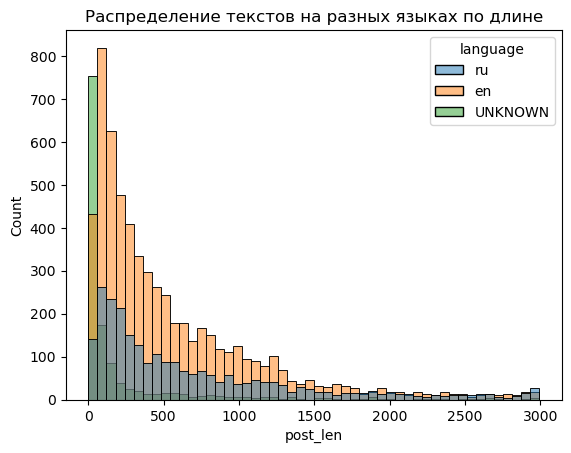

In [197]:
sns.histplot(posts, x='post_len',
                    hue="language").set_title('Распределение текстов на разных языках по длине')
plt.show()

Большинство текстов на русском и английском языках длиной меньше 500 символов. Также подтверждается гипотеза, что метка UNKNOWN в значимой степени связана с длиной текста (гистограмма резче остальных показывает спад количества с увеличением длины).

In [198]:
posts_en = posts.query('language == "en"')
posts_en.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len
6106,https://www.linkedin.com/in/artsiom-liskevich/...,NaN,Software development process scares a lot of p...,0,0.0,0.0,en,514
7065,https://www.linkedin.com/in/tentser/recent-act...,NaN,Hi FolksWe have launched our brand new chrome ...,13,0.0,5.0,en,162
7113,https://www.linkedin.com/in/comisarov/recent-a...,NaN,"When you switch to a new system, transfer oper...",7,0.0,3.0,en,354
9667,https://www.linkedin.com/in/vladimirskabelkin,NaN,SpeedyZero is a distributed model-based RL tra...,NaN,NaN,NaN,en,140
5525,https://www.linkedin.com/in/dan-henyk/recent-a...,NaN,"2,000 innocent Ukrainians dead. That's thousan...",0,1.0,0.0,en,373


In [199]:
posts_ru = posts.query('language == "ru"')
posts_ru.sample(5)

,profile_url,post_url,post,reactions_cnt,comments_cnt,reposts_cnt,language,post_len
4889,https://www.linkedin.com/in/talap-kenzhebaev/r...,NaN,"С удовольствием сообщаю, что я начинаю работу ...",105,22.0,0.0,ru,106
329,https://www.linkedin.com/in/%D0%B0%D0%BB%D0%B5...,NaN,Интересная статья про успех и неудачи от компа...,2,1.0,0.0,ru,310
166,https://www.linkedin.com/in/mikhailsolovyev/re...,NaN,Примерно в 35 лет я захотел сменить сферу деят...,56,5.0,0.0,ru,1840
2276,https://www.linkedin.com/in/damiruali/recent-a...,NaN,ALTEL Kazakhtelecom JSC вы на категорию польз...,0,0.0,0.0,ru,608
2285,https://www.linkedin.com/in/damiruali/recent-a...,NaN,Курс FlutterFlow 3.0NO CODE ИНЖЕНЕР МОБИЛЬНЫХ ...,9,0.0,2.0,ru,245


# Подготовка текстов

Скачаем и загрузим модели (библиотеку spacy предварительно установили)

In [200]:
! python -m spacy download ru_core_news_sm >> None
! python -m spacy download en_core_web_sm >> None

In [201]:
model_en = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
model_ru = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

Сохраним посты на английском и русском языках, как списки

In [202]:
posts_ru_list = list(posts_ru['post'])
posts_en_list = list(posts_en['post'])

Лемматизируем посты и сохраним результат в файлы

In [203]:
res_ru = []
for doc in model_ru.pipe(posts_ru_list, disable=["tagger", "parser"]):
    res_ru.append([token.lemma_ for token in doc])
    
with open("lemmas_ru.json", "w") as fid:
    json.dump({"lemmas_ru": res_ru}, fid)

In [204]:
res_en = []
for doc in model_en.pipe(posts_en_list, disable=["tagger", "parser"]):
    res_en.append([token.lemma_ for token in doc])
    
with open("lemmas_en.json", "w") as fid:
    json.dump({"lemmas_en": res_en}, fid)

C:\Dev\Jupyter\dist\pyenv3.10-win64\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Проконтролируем, что получилось.

In [205]:
", ".join(res_ru[np.random.randint(len(res_ru))])

'с, удовольствие, сообщать, ,, что, я, начинать, работа, в, новый, должность, \xa0, –, product, designer, в, компания, мтс, !'

In [206]:
", ".join(res_en[np.random.randint(len(res_en))])

'best, 12, ai, tools, to, try, in, 2023try, this, amazing, ai, tool, now, :, https://lnkd.in/dqrsrh3w, 🔵, 𝗙𝗼𝗹𝗹𝗼𝘄, 𝗠𝗲, 𝗼𝗻, 𝗧𝗲𝗹𝗲𝗴𝗿𝗮𝗺, 𝗳𝗼𝗿, 𝗔𝗺𝗮𝘇𝗶𝗻𝗴, 𝗜𝗻𝘀𝗶𝗴𝗵𝘁𝘀, 𝗼𝗻, 𝗔𝗜, :, https://lnkd.in/gxh8jpux, 🔵, 𝗙𝗼𝗹𝗹𝗼𝘄, 𝗠𝗲, 𝗼𝗻, 𝗧𝘄𝗶𝘁𝘁𝗲𝗿, 𝗳𝗼𝗿, 𝗔𝗺𝗮𝘇𝗶𝗻𝗴, 𝗜𝗻𝘀𝗶𝗴𝗵𝘁𝘀, 𝗼𝗻, 𝗔𝗜, :, \xa0, https://lnkd.in/d-rtvz2h, 🔵, 📍, chatgpt, solves, anthing, -, https://chat.openai.com, 📍, writesonic, writes, anything,  , -, https://lnkd.in/dbktmmae, 📍, midjourney, generates, art, -,   , https://lnkd.in/d7gngvhk, 📍, replit, generates, code, -, https://lnkd.in/dn-kjheg, 📍, synthesia, generates, video, -, https://www.synthesia.io, 📍, soundraw, generates, music, -, https://soundraw.io/, 📍, fliki, generates, tiktoks, -, https://fliki.ai/, 📍, starry, generates, avatars, -,  , https://lnkd.in/dh_vcdfn, 📍, slidesai.io, generates, ppt, -, https://www.slidesai.io/, 📍, remini, edit, pictures, -, https://remini.ai/, 📍, pictory, edit, videos, -, https://pictory.ai/, 📍, wordtune, summarize, notes, -, https://www.wordtune.com/, follow, aaka

Остаётся констатировать, что лемматизация прошла успешно. Почистим тексты:

In [207]:
word_pattern_ru = re.compile("^[а-я]*$")
word_pattern_en = re.compile("^[a-z]*$")

In [208]:
def remove_symbols_ru(doc):
    return [token for token in doc if word_pattern_ru.match(token)]

def remove_symbols_en(doc):
    return [token for token in doc if word_pattern_en.match(token)]

In [209]:
corpus_ru = list(map(remove_symbols_ru, res_ru))
corpus_en = list(map(remove_symbols_en, res_en))

In [210]:
", ".join(corpus_ru[np.random.randint(len(corpus_ru))])

'только, утихли, страсть, по, как, на, свет, появиться, более, продвинутый, и, умный, если, с, предыдущий, я, игрался, через, знакомых, то, с, новый, версия, я, решить, побеседовать, лично, краткий, итог, это, не, такой, уж, и, волшебство, массовый, увольнение, точно, не, будет, тот, персонал, который, способный, заменить, нейросеть, как, правило, брать, не, только, и, не, совсем, для, тот, функция, которые, выполнять, я, прийти, к, такой, вывод, прочесть, в, этот, нейросети, будущее, технология, информационныетехнологии, нейросеть, нейронка, чат'

In [211]:
", ".join(corpus_en[np.random.randint(len(corpus_en))])

'improving, your, skills, and, knowledge, as, a, developer, or, software, engineer, is, essential, and, technical, books, can, help, they, offer, insights, into, programming, languages, frameworks, and, industry, trends, check, out, some, of, our, top, clean, code, and, clean, architecture, by, robert, herding, cats, a, primer, for, programmers, who, lead, programmers, by, rainwater, what, are, some, of, your, favorite, technical, books, share, your, recommendations, in, the, comments, below, let, us, help, each, other, grow, softwareengineering, softwarearchitecture, books, technicalbooks, softwareengineer, programming'

Отличный результат. Удалим стоп-слова и будет идеально.

# Векторизация текстов

 Подгружаем и формируем список стоп-слов

In [212]:
stop_words_ru = stopwords.words('russian')
stop_words_en = stopwords.words('english')

# сформируем единый список для обоих языков - это не помешает работе векторайзера
stop_words = stop_words_ru + stop_words_en

Объединим отдельные слова обратно в тексты и проконтролируем результат

In [213]:
docs_en = [" ".join(tokens) for tokens in corpus_en]
docs_en[:3]

['i hiring know anyone who might be interested',
 'hello everyone i ecstatic to announce my new role as ceo of metakratos studio a seasoned it firm known for delivering advanced software solutions across various industries such as finance it blockchain industrial automatization security edtech and advertising with years of experience in empowering businesses of all sizes to achieve rapid growth and effortless scaling metakratos studio has built a reputation for excellence and innovation i honored to be leading this incredible team and eager to continue the company legacy of pushing the boundaries of technology as we embark on this journey together i look forward to tackling new challenges seizing opportunities and fostering a culture of collaboration and creativity within our team i committed to ensuring that metakratos studio remains at the forefront of innovation and continues to make a lasting impact on the industries we serve i invite you to follow the metakratos studio community o

In [214]:
docs_ru = [" ".join(tokens) for tokens in corpus_ru]
docs_ru[:3]

['кстати говорить теперь подкаст миражи доступный в соцсеть вконтакте наконец разобраться как туда прикрутить мираж',
 'хэй честной народ искать векторный иллюстратор на проект с возможный длительный сотрудничество по итог можно уровень иллюстрация не плохой чем в пример ты уметь так рисовать напиши мне в личка иллюстрация проект',
 'новый пост подкаст мираж на весь платформа в аудио инстаграм а патреоне психология психологиячеловека психологияжизни психологияличности личностныйрост подкаст подкастмиражи маркетинг осознанность мысль мысливслух установка влияние подсознаниеиспользованные звук музыка и картинка аудиоцитата из фильм формула любовь марка']

Успешно. Векторизируем тексты

In [215]:
# создаём "векторизатор" :-)
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.9)

Векторизируем тексты на двух языках, создадим список векторизированных слов и проконтролируем результат

In [217]:
x_ru = tfidf.fit_transform(docs_ru)
id2word_ru = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

x_ru.shape

(2468, 1929)

In [218]:
x_en = tfidf.fit_transform(docs_en)
id2word_en = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

x_en.shape

(6056, 3648)

# LDA

Сформируем топ-10 тем

In [220]:
n_topics = 10

In [226]:
lda_ru = LatentDirichletAllocation(n_components=n_topics, random_state=10723)
topics_ru = lda_ru.fit_transform(x_ru)
topics_ru.shape

(2468, 10)

In [227]:
lda_en = LatentDirichletAllocation(n_components=n_topics, random_state=10723)
topics_en = lda_en.fit_transform(x_en)
topics_en.shape

(6056, 10)

## Ключевые слова и типичные статьи

Взглянем на ключевые слова по каждой теме. Для этого напишем функцию

In [237]:
def topic_text(id2word, lda, topics, posts, n_topics=n_topics):
    for i in range(n_topics):
        c = lda.components_[i, :]
        topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
        doc_id = np.argmax(topics[:, i])
        print("Тема",i+1, ":")
        print(", ".join(topic_tokens))
        print("***************************")
        print("Текст на тему",i+1, ":")
        print(posts.iloc[doc_id]['post'])
        print("\n ")

### Русский язык

In [238]:
topic_text(id2word_ru, lda_ru, topics_ru, posts_ru)

Тема 1 :
собес, потерять, программист, системный, стол, войтивайти, дизайнер, ловить, искать, разработчик, желательный, крутой, александр, руководитель, зарабатывать, живой, гайд, занятость, вакансия, аналитик
***************************
Текст на тему 1 :
Ты UI/UX Дизайнер? Ты ищешь работу? 🤔 Тогда тебе к нам в Банк ЦентрКредит ✔ Нам нужны специалисты от middle уровняРабота в г. Алматы (гибрид)Ссылка на вакансию ⬇ https://lnkd.in/e2qxAg_XПишите по номеру: +7 702 196 7205 (Кристина)#вакансия #designer #дизайнер

 
Тема 2 :
находиться, репостам, гибрид, приложение, сообщать, предложение, поиск, радость, бизнес, привет, фронтенд, всем, услуги, оказывать, ищу, страница, разработчик, просмотреть, услуга, разработка
***************************
Текст на тему 2 :
С радостью сообщаю, что я оказываю бизнес-услуги в LinkedIn #OpenForBusiness. Просмотрите мою страницу услуг «Бизнес-аналитика, Проектирование пользовательского интерфейса (UED), Разработка баз данных, Разработка пользовательского ПО,

### Английский язык

In [239]:
topic_text(id2word_en, lda_en, topics_en, posts_en)

Тема 1 :
ruby, webdevelopmentcompany, month, office, rubydeveloper, heading, agency, mentoring, frorex, last, sloboda, hiringdevelopers, studio, explanation, added, vr, important, best, profile, slideshare
***************************
Текст на тему 1 :
🖐 Dear fellows !It’s a terrifying time for Ukraine and our people. We are in the middle of unimaginable aggression and fighting for our freedom as hard as we can!Every support counts #StandWithUkraine!Dribbble: https://lnkd.in/e48Tb4EZ#dribbbler #dribblersofinstagram #dribbbleinspiration #dribbleui #dailywebdesign #uxdesign #uidesign #uitrends #usability #uxui #uxdesigner #uidesigns #uidesigners #webdesigninspiration #uxdesigninspiration #uxdesignagency #userinterface #uxigers #designfeedinstagram #uxd #websitedesigning #websitedesign #лендинг #webdevelopmentcompany #webdev #frorex #studio #agency #linkedin #dribbble

 
Тема 2 :
startup, let, football, us, insurance, networking, event, insurtech, attending, entrepreneur, see, earned, oppo